In [1]:
#!/usr/bin/env python2
#Inspire du fichier train_fcn8.py

import os
import argparse
import time
from getpass import getuser
from distutils.dir_util import copy_tree

import numpy as np
import random
import theano
import theano.tensor as T
from theano import config
import lasagne
from lasagne.regularization import regularize_network_params
from lasagne.objectives import categorical_crossentropy

import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import gridspec

from metrics import jaccard, accuracy, crossentropy
from data_loader.cortical_layers import Cortical4LayersDataset, Cortical6LayersDataset
from simple_model_1path import build_simple_model

%matplotlib inline

In [2]:
# exp_name = 'simple_model_lrate=0.0005_fil=64_fsizes=[7, 15, 25, 49]_depth=4_raw_decay=0.001_pat=25'


# #Model hyperparameters
# n_filters = 64
# filter_size = [7,15,25,49]  
# depth  = 4
# data_augmentation={} #{'horizontal_flip': True, 'fill_mode':'constant'}

# #Training loop hyperparameters
# weight_decay=0.001
# num_epochs=500
# max_patience=25
# resume=False
# learning_rate_value = 0.0005
# #learning rate is defined below as a theano variable.

# #Hyperparameters for the dataset loader
# batch_size=[500,500,1]
# smooth_or_raw = 'raw'
# shuffle_at_each_epoch = True 
# minibatches_subset = 1

In [3]:
#exp_name = 'simple_model_lrate=0.0005_fil=64_fsizes=[25]_depth=8_data=both_decay=0.001_pat=25nothreads'
dataset = '6cortical_layers'
exp_name = 'simple_model_lrate=0.0005_fil=64_fsizes=[25]_depth=8_data=both_decay=0.001_pat=25'

#Model hyperparameters
n_filters = 64
filter_size = [25]  
depth  = 8
data_augmentation={} #{'horizontal_flip': True, 'fill_mode':'constant'}

#Training loop hyperparameters
weight_decay=0.001
num_epochs=500
max_patience=25
resume=False
learning_rate_value = 0.0005
#learning rate is defined below as a theano variable.

#Hyperparameters for the dataset loader
batch_size=[1000,1000,1]
smooth_or_raw = 'both'
n_in_channels = 2 if smooth_or_raw=='both' else 1
shuffle_at_each_epoch = True 
minibatches_subset = 0

n_layers = 6 #number of cortical layers

In [4]:
#SAVEPATH = '/Tmp/larocste/cortical_layers'
LOADPATH = '/data/lisatmp4/larocste/cortical_layers'
WEIGHTS_PATH = LOADPATH

#dataset = 'cortical_layers'
dataset='6cortical_layers' if n_layers==6 else '4cortical_layers'
weight_path = os.path.join(WEIGHTS_PATH, dataset, exp_name, 'new_fcn1D_model_best.npz')

print 'weight path is ' , weight_path

weight path is  /data/lisatmp4/larocste/cortical_layers/6cortical_layers/simple_model_lrate=0.0005_fil=64_fsizes=[25]_depth=8_data=both_decay=0.001_pat=25/new_fcn1D_model_best.npz


In [5]:
#
# Build dataset iterator
#

if n_layers==4:
    train_iter = Cortical4LayersDataset(
        which_set='train',
        smooth_or_raw = smooth_or_raw,
        batch_size=batch_size[0],
        data_augm_kwargs=data_augmentation,
        shuffle_at_each_epoch = shuffle_at_each_epoch,
        return_one_hot=False,
        return_01c=False,
        return_list=False,
        use_threads=True)

    val_iter = Cortical4LayersDataset(
        which_set='valid',
        smooth_or_raw = smooth_or_raw,
        batch_size=batch_size[1],
        shuffle_at_each_epoch = shuffle_at_each_epoch,
        return_one_hot=False,
        return_01c=False,
        return_list=False,
        use_threads=True)
elif n_layers ==6:
    train_iter = Cortical6LayersDataset(
        which_set='train',
        smooth_or_raw = smooth_or_raw,
        batch_size=batch_size[0],
        data_augm_kwargs=data_augmentation,
        shuffle_at_each_epoch = shuffle_at_each_epoch,
        return_one_hot=False,
        return_01c=False,
        return_list=False,
        use_threads=True)

    val_iter = Cortical6LayersDataset(
        which_set='valid',
        smooth_or_raw = smooth_or_raw,
        batch_size=batch_size[1],
        shuffle_at_each_epoch = shuffle_at_each_epoch,
        return_one_hot=False,
        return_01c=False,
        return_list=False,
        use_threads=True)
    

test_iter = None



n_batches_train = train_iter.nbatches
n_batches_val = val_iter.nbatches
n_batches_test = test_iter.nbatches if test_iter is not None else 0
n_classes = train_iter.non_void_nclasses
void_labels = train_iter.void_labels





In [6]:
#
# Define symbolic variables
#
input_var = T.tensor3('input_var') #n_example*nb_in_channels*ray_size
target_var = T.ivector('target_var') #n_example*ray_size

learn_step=  theano.shared(np.array(learning_rate_value, dtype=theano.config.floatX))

In [7]:
#
# Build model and assign trained weights
#
simple_net_output, net = build_simple_model(input_var,
                    filter_size = filter_size,
                    n_filters = n_filters,
                    depth = depth,
                    nb_in_channels = 2,#n_in_channels,
                    n_classes = n_classes,
                    last_filter_size=1)#must be set to 1 for the new models
                    #in the last version, last_filter_size was uncorrectly set to 3
                    #so, in order to recover/resassign weights correctly, must be a
                    #"new" parameter

print 'Done building model'

with np.load(weight_path) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    
nlayers = len(lasagne.layers.get_all_params(simple_net_output))
lasagne.layers.set_all_param_values(simple_net_output, param_values[:nlayers])

print 'Done assigning weights'

Done building model
Done assigning weights


In [8]:
print "Defining and compiling test functions"
test_prediction = lasagne.layers.get_output(simple_net_output[0],
                                            deterministic=True)
test_loss = categorical_crossentropy(test_prediction, target_var)
test_loss = test_loss.mean()
test_acc, test_acc_per_sample = accuracy(test_prediction, target_var, void_labels)
test_jacc = jaccard(test_prediction, target_var, n_classes)

test_fn = theano.function([input_var, target_var], [test_loss, test_acc,
                                                   test_jacc, test_acc_per_sample])
print "Done"

Defining and compiling test functions
Done


In [9]:
#Function computing the prediction with current parameters (for visualization)
pred = theano.function([input_var], lasagne.layers.get_output(net['probs_reshape'],
                                            deterministic=True))

In [10]:
#To visualize the ray 
def make_2Darray(arr, height = 25):
    arr = np.reshape(arr, (1,arr.shape[0]))
    x = np.repeat(arr, height, 0)
    return x

In [11]:
def plot_true_predicted_labels(X_batch, L_batch, idx_batch, smooth_or_raw='both', index = -1, which_set=''):
    #Get random sample
    if index != -1:
        idx = index
    else:
        idx = random.randint(0,X_batch.shape[0]-1)
    
    real_idx = idx_batch[idx]

    ray = X_batch[idx][0]
    true_labels = L_batch[idx*200:(idx+1)*200]
    
    predicted_labels = np.argmax(pred(X_batch), axis=2)[idx]
    
    true_vs_predicted = np.concatenate((make_2Darray(true_labels),
                                        make_2Darray(predicted_labels)), axis = 0)

    
    if smooth_or_raw=='both':
        plt.title('Smooth vs raw data ' + which_set + ' idx = '+ str(real_idx))
        data = np.concatenate((make_2Darray(X_batch[idx][0]),
                                   make_2Darray(X_batch[idx][1])), axis=0)
        plt.imshow(data, cmap='gray', interpolation='none')
        plt.figure()
    else : 
        plt.title(smooth_or_raw + ' data ' + which_set + ' idx = '+ str(real_idx))
        plt.imshow(make_2Darray(X_batch[idx][0]), cmap='gray', interpolation='none')
        plt.figure()
        

    plt.show()
#     plt.title('Ground truth vs predicted labels '+ which_set + ' idx = '+ str(real_idx))
    plt.imshow(true_vs_predicted, interpolation='none', vmin=0, vmax=n_classes)
#     plt.figure()
    

    plt.show()

In [12]:
with open('/Tmp/romerosa/datasets/cortical_layers/6layers_segmentation/training_regions.txt') as f :
    idx2regions = f.readlines()
    idx2regions = np.array([int(i) for i in idx2regions])
    
n_regions = np.max(idx2regions)
n_per_region_all_training_set =[list(idx2regions).count(i) for i in range(n_regions+1)]
print 'n_regions :', n_regions
print 'n_per_region_all_training_set :', n_per_region_all_training_set

n_regions : 42
n_per_region_all_training_set : [0, 882, 0, 3331, 1490, 1463, 1454, 1583, 5264, 4037, 2908, 2658, 1635, 3001, 2082, 1250, 1049, 2997, 3833, 362, 1203, 1268, 344, 2251, 2756, 3238, 1933, 3004, 1951, 2366, 3144, 1655, 2765, 700, 605, 1766, 1577, 13, 918, 396, 612, 1248, 1149]


In [17]:
def test_and_plot(exp_name, test_iter, plot_during_testing = True, ratios=[0.80, 0.85, 0.90,0.95]):
    
    treshold = 0.9
    
    worst_indices = []
    
    n_batches_test = test_iter.nbatches
    cost_test_tot = 0
    acc_test_tot = 0
    sample_acc_test_tot = np.array([0.0 for i in range(len(ratios))])
    jacc_num_test_tot = np.zeros((1, n_classes))
    jacc_denom_test_tot = np.zeros((1, n_classes))
    
    
#     per_region_accuracy_tot = np.array([0.0 for i in range(n_regions + 1)])
#     n_per_region_test_tot = np.array([0 for i in range(n_regions + 1)])

    for i in range(n_batches_test):
        print 'Batch', i
        # Get minibatch

        test_batch = test_iter.next()
        X_test_batch, L_test_batch, idx_test_batch = test_batch['data'], test_batch['labels'],test_batch['filenames'][0]   
        L_test_batch = np.reshape(L_test_batch, np.prod(L_test_batch.shape))
        
        
        
        
        # Test step
        cost_test, acc_test, jacc_test, acc_test_per_sample = test_fn(X_test_batch, L_test_batch)
        jacc_num_test, jacc_denom_test = jacc_test

        acc_test_per_sample_mean = [np.mean([(i>=ratio) for i in acc_test_per_sample]) for ratio in ratios]
        
#         worst_indices += [(idx_test_batch[i], acc_test_per_sample[i], idx2regions[idx_test_batch[i]]) 
#                           for i in range(len(acc_test_per_sample)) 
#                           if acc_test_per_sample[i]<= treshold]
#         print worst_indices
        
#         regions_test_batch = idx2regions[idx_test_batch]
#         n_per_region_test_batch = np.array([(regions_test_batch==i).sum(0) for i in range(43)])
#         per_region_accuracy_batch = [  (np.array(acc_test_per_sample)*np.array([regions_test_batch==i])).sum() 
#                                      for i in range(n_regions+1) ]
        
        
#         #Update total accuracy and stuff
#         n_per_region_test_tot += n_per_region_test_batch
#         per_region_accuracy_tot += np.array(per_region_accuracy_batch)        
        

        acc_test_tot += acc_test
        cost_test_tot += cost_test
        sample_acc_test_tot += acc_test_per_sample_mean
        jacc_num_test_tot += jacc_num_test
        jacc_denom_test_tot += jacc_denom_test

        print 'before plots'
        if plot_during_testing:
            plot_true_predicted_labels(X_test_batch, L_test_batch, idx_test_batch,
                                       smooth_or_raw=smooth_or_raw, index = -1,
                                      which_set = '')
        print 'end of the loop'

    err_test = cost_test_tot/n_batches_test
    acc_test = acc_test_tot/n_batches_test
    jacc_test = np.mean(jacc_num_test_tot / jacc_denom_test_tot)
    per_sample_acc_test = sample_acc_test_tot/n_batches_test
    
#     print 'n_per region ', n_per_region_test_tot
#     per_region_accuracy_tot = per_region_accuracy_tot/n_per_region_test_tot
#     print 'Per region accuracy', per_region_accuracy_tot
        

    out_str = "FINAL MODEL: err test % f, acc test %f, jacc test %f, 0.9 accuracy %f"
    out_str = out_str % (err_test,
                         acc_test,
                         jacc_test,
                         per_sample_acc_test[2])
    out_str2 = 'Per sample accuracy: ' + str(per_sample_acc_test) + ' achieve ' + str(ratios)+ ' accuracy'
    print exp_name
    print out_str
    print out_str2
    
#     print 'worst indices ',treshold, worst_indices
#     return n_per_region_test_tot, per_region_accuracy_tot, worst_indices
    

Batch 0
before plots


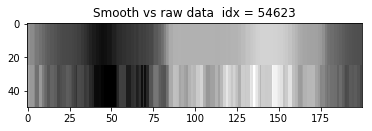

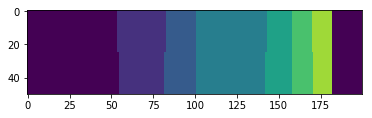

end of the loop
Batch 1
before plots


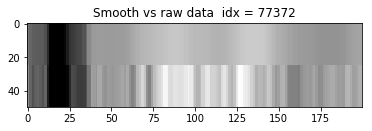

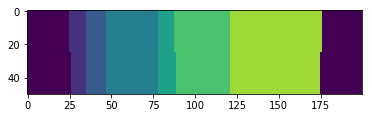

end of the loop
Batch 2
before plots


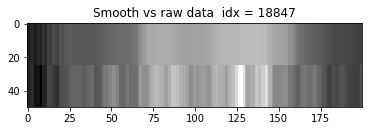

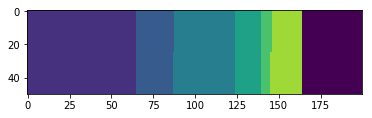

end of the loop
Batch 3
before plots


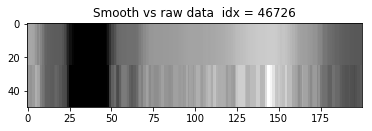

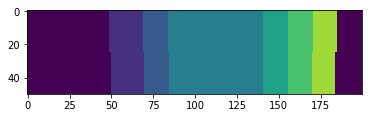

end of the loop
Batch 4
before plots


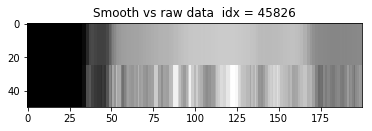

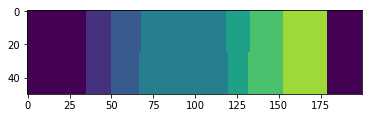

end of the loop
Batch 5
before plots


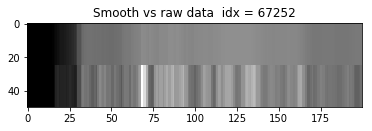

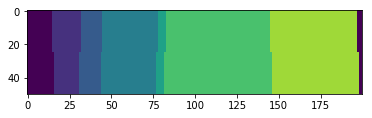

end of the loop
Batch 6
before plots


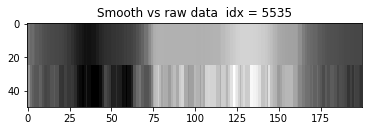

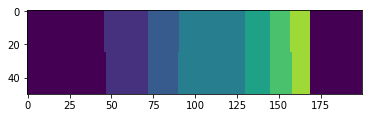

end of the loop
Batch 7
before plots


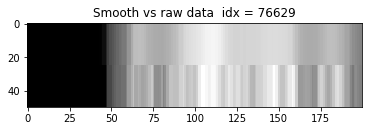

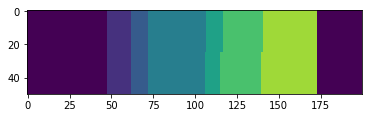

end of the loop
Batch 8
before plots


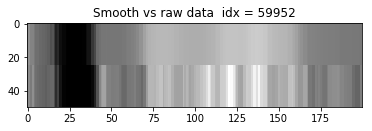

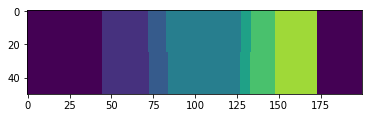

end of the loop
Batch 9
before plots


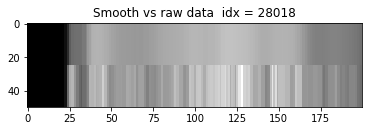

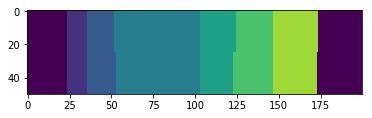

end of the loop
Batch 10
before plots


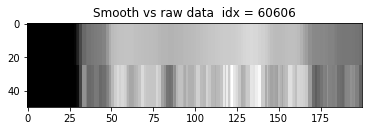

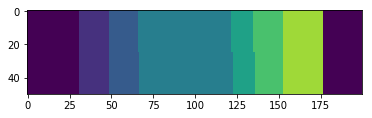

end of the loop
Batch 11
before plots


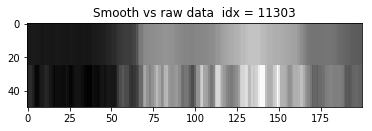

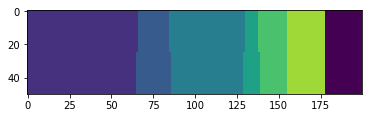

end of the loop
simple_model_lrate=0.0005_fil=64_fsizes=[25]_depth=8_data=both_decay=0.001_pat=25
FINAL MODEL: err test  0.057826, acc test 0.977109, jacc test 0.941309, 0.9 accuracy 0.993269
Per sample accuracy: [ 0.99941667  0.99825     0.99326916  0.94832572] achieve [0.8, 0.85, 0.9, 0.95] accuracy


In [18]:
test_and_plot(exp_name, val_iter)

In [16]:
def sort_from_region(worst_indices):
    idx = [elem[0] for elem in worst_indices]
    argsort = np.argsort(idx)
    #print argsort
    worst_indices_sorted = np.array(worst_indices)[argsort]
    worst_indices_sorted = [(int(w[0]), w[1], int(w[2])) for w in worst_indices_sorted]
    
    return worst_indices_sorted

batch to load :  [28108, 26286, 29057, 55920, 30251, 64668, 74544, 3835, 27771, 17934, 8187, 58548, 15625, 19902, 11302, 66753, 46346, 19372, 73241, 12655, 20330, 18884, 57360, 9039, 71658, 44227, 53080, 59610, 18703, 58261, 55914, 53714, 11735, 8778, 46667, 60877, 22469, 55580, 22460, 27968, 3631, 53202, 74176, 11248, 11826, 47493, 22758, 71775, 25649, 49879, 1040, 76293, 34611, 5860, 5329, 40356, 76843, 22652, 2514, 40026, 7043, 33002, 27074, 60402, 39877, 57463, 58737, 19216, 26830, 14924, 57257, 140, 26860, 35849, 19120, 14259, 29460, 4577, 7063, 72099, 47161, 46301, 50748, 67048, 68920, 52359, 26677, 8911, 69748, 4947, 7537, 41129, 38219, 73779, 21079, 62060, 41813, 64637, 20746, 48789, 17238, 13379, 34388, 43336, 831, 14971, 13929, 10574, 77925, 49297, 45670, 19511, 2754, 13026, 3906, 72503, 70644, 58674, 31304, 28836, 42163, 28557, 2259, 19270, 20992, 30380, 16794, 65933, 26222, 48600, 50693, 62650, 14281, 36088, 54744, 34399, 38162, 31293, 20431, 9314, 58957, 65953, 28397, 5475

Batch 0
before test_iter.next()
after
after spliting
[(25968, 0.89999998, 7), (58491, 0.86500001, 29), (37455, 0.73499995, 16), (71280, 0.89499998, 32), (22573, 0.89999998, 9), (6451, 0.89999998, 6)]
before plots


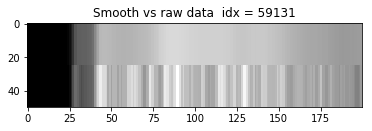

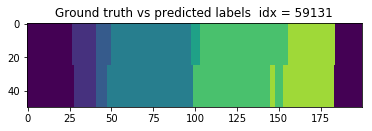

end of the loop
Batch 1
before test_iter.next()
after
after spliting
[(25968, 0.89999998, 7), (58491, 0.86500001, 29), (37455, 0.73499995, 16), (71280, 0.89499998, 32), (22573, 0.89999998, 9), (6451, 0.89999998, 6), (24660, 0.88999999, 12), (43092, 0.88999999, 23), (35713, 0.84499997, 14), (69869, 0.82999998, 31), (66875, 0.80500001, 36), (57180, 0.89499998, 25), (4997, 0.80500001, 3), (27609, 0.89999998, 18), (40507, 0.83499998, 13)]
before plots


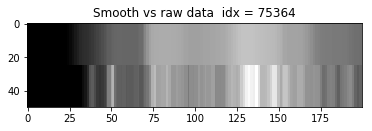

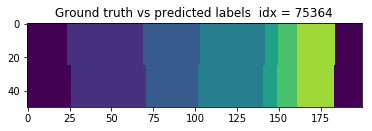

end of the loop
n_per region  [  0  21   0  89  43  36  44  28 119 122  66  76  51  77  52  33  30  77
 103   6  31  35  11  54  58  78  43  71  43  74  67  44  76  23  25  46
  39   0  22   9  20  38  20]
Per region accuracy [        nan  0.97857137         nan  0.97646066  0.97988368  0.97916661
  0.97397722  0.97714281  0.97815124  0.97754097  0.97696969  0.97657886
  0.97598038  0.97662334  0.97740382  0.98015149  0.97033332  0.97928565
  0.97660194  0.98083329  0.97532251  0.97671422  0.97954542  0.97796288
  0.97870682  0.97769229  0.97906978  0.97718311  0.97732557  0.97513508
  0.98037304  0.97488629  0.97493418  0.97695649  0.97639996  0.97978256
  0.97205123         nan  0.97704541  0.985       0.97699995  0.97710522
  0.97099996]
simple_model_lrate=0.0005_fil=64_fsizes=[25]_depth=8_data=both_decay=0.001_pat=25
FINAL MODEL: err test  0.009660, acc test 0.162853, jacc test 0.941540, 0.9 accuracy 0.165417
Per sample accuracy: [ 0.16658333  0.16616667  0.16541667  0.15766667] ac

In [17]:
n_per_region_val, per_region_accuracy_val, worst_indices_val = test_and_plot(exp_name, val_iter)

Batch 0
[(28965, 0.875), (33486, 0.89999998), (61571, 0.87), (68785, 0.89999998), (75916, 0.875)]
[(28965, 0.875), (33486, 0.89999998), (61571, 0.87), (68785, 0.89999998), (75916, 0.875)]


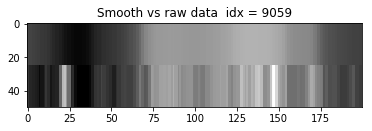

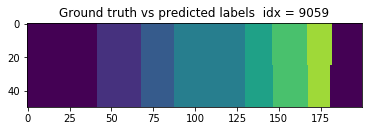

Batch 1
[(11222, 0.87), (28702, 0.88999999), (32489, 0.89999998), (40974, 0.73499995), (68327, 0.79999995), (76827, 0.78999996)]
[(28965, 0.875), (33486, 0.89999998), (61571, 0.87), (68785, 0.89999998), (75916, 0.875), (11222, 0.87), (28702, 0.88999999), (32489, 0.89999998), (40974, 0.73499995), (68327, 0.79999995), (76827, 0.78999996)]


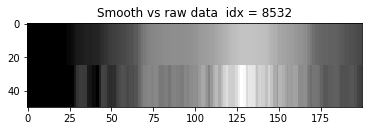

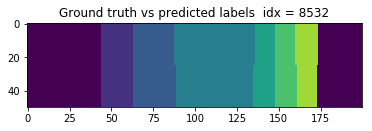

Batch 2
[]
[(28965, 0.875), (33486, 0.89999998), (61571, 0.87), (68785, 0.89999998), (75916, 0.875), (11222, 0.87), (28702, 0.88999999), (32489, 0.89999998), (40974, 0.73499995), (68327, 0.79999995), (76827, 0.78999996)]


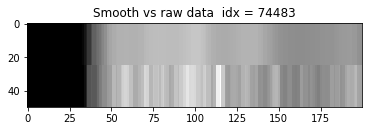

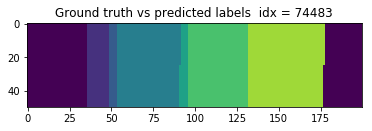

Batch 3
[(17967, 0.89999998), (35338, 0.88), (39689, 0.89499998), (58779, 0.88), (63527, 0.89999998), (72863, 0.83499998)]
[(28965, 0.875), (33486, 0.89999998), (61571, 0.87), (68785, 0.89999998), (75916, 0.875), (11222, 0.87), (28702, 0.88999999), (32489, 0.89999998), (40974, 0.73499995), (68327, 0.79999995), (76827, 0.78999996), (17967, 0.89999998), (35338, 0.88), (39689, 0.89499998), (58779, 0.88), (63527, 0.89999998), (72863, 0.83499998)]


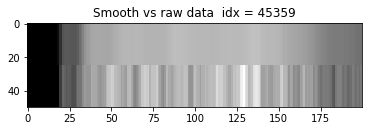

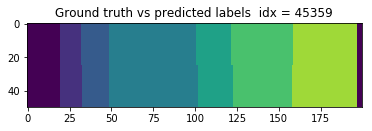

Batch 4
[(24014, 0.87), (35646, 0.83999997), (42518, 0.87), (58750, 0.83499998), (68681, 0.89999998), (70579, 0.89999998), (75420, 0.89499998), (77545, 0.89499998)]
[(28965, 0.875), (33486, 0.89999998), (61571, 0.87), (68785, 0.89999998), (75916, 0.875), (11222, 0.87), (28702, 0.88999999), (32489, 0.89999998), (40974, 0.73499995), (68327, 0.79999995), (76827, 0.78999996), (17967, 0.89999998), (35338, 0.88), (39689, 0.89499998), (58779, 0.88), (63527, 0.89999998), (72863, 0.83499998), (24014, 0.87), (35646, 0.83999997), (42518, 0.87), (58750, 0.83499998), (68681, 0.89999998), (70579, 0.89999998), (75420, 0.89499998), (77545, 0.89499998)]


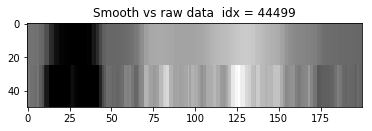

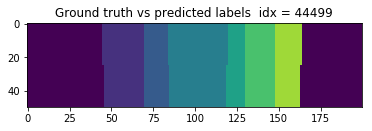

Batch 5
[(4541, 0.89499998), (9741, 0.82999998), (10798, 0.88999999), (27388, 0.88), (31578, 0.81999999), (37991, 0.85999995), (38200, 0.83499998), (45302, 0.88999999), (67201, 0.84499997), (72757, 0.71999997), (75953, 0.85999995)]
[(28965, 0.875), (33486, 0.89999998), (61571, 0.87), (68785, 0.89999998), (75916, 0.875), (11222, 0.87), (28702, 0.88999999), (32489, 0.89999998), (40974, 0.73499995), (68327, 0.79999995), (76827, 0.78999996), (17967, 0.89999998), (35338, 0.88), (39689, 0.89499998), (58779, 0.88), (63527, 0.89999998), (72863, 0.83499998), (24014, 0.87), (35646, 0.83999997), (42518, 0.87), (58750, 0.83499998), (68681, 0.89999998), (70579, 0.89999998), (75420, 0.89499998), (77545, 0.89499998), (4541, 0.89499998), (9741, 0.82999998), (10798, 0.88999999), (27388, 0.88), (31578, 0.81999999), (37991, 0.85999995), (38200, 0.83499998), (45302, 0.88999999), (67201, 0.84499997), (72757, 0.71999997), (75953, 0.85999995)]


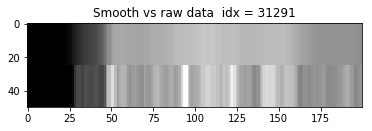

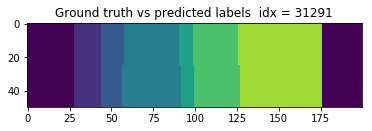

Batch 6
[(9754, 0.88499999), (11219, 0.83999997), (30683, 0.88999999), (31383, 0.83499998), (55341, 0.88999999), (55360, 0.88499999), (75831, 0.89999998)]
[(28965, 0.875), (33486, 0.89999998), (61571, 0.87), (68785, 0.89999998), (75916, 0.875), (11222, 0.87), (28702, 0.88999999), (32489, 0.89999998), (40974, 0.73499995), (68327, 0.79999995), (76827, 0.78999996), (17967, 0.89999998), (35338, 0.88), (39689, 0.89499998), (58779, 0.88), (63527, 0.89999998), (72863, 0.83499998), (24014, 0.87), (35646, 0.83999997), (42518, 0.87), (58750, 0.83499998), (68681, 0.89999998), (70579, 0.89999998), (75420, 0.89499998), (77545, 0.89499998), (4541, 0.89499998), (9741, 0.82999998), (10798, 0.88999999), (27388, 0.88), (31578, 0.81999999), (37991, 0.85999995), (38200, 0.83499998), (45302, 0.88999999), (67201, 0.84499997), (72757, 0.71999997), (75953, 0.85999995), (9754, 0.88499999), (11219, 0.83999997), (30683, 0.88999999), (31383, 0.83499998), (55341, 0.88999999), (55360, 0.88499999), (75831, 0.8999999

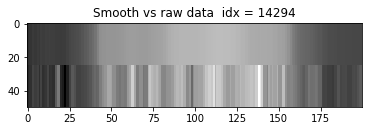

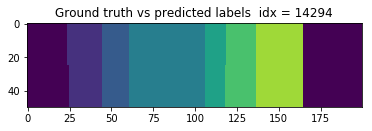

Batch 7
[(5652, 0.83999997), (10813, 0.875), (17808, 0.88999999), (24640, 0.88), (43594, 0.80500001), (72761, 0.70999998), (76798, 0.87)]
[(28965, 0.875), (33486, 0.89999998), (61571, 0.87), (68785, 0.89999998), (75916, 0.875), (11222, 0.87), (28702, 0.88999999), (32489, 0.89999998), (40974, 0.73499995), (68327, 0.79999995), (76827, 0.78999996), (17967, 0.89999998), (35338, 0.88), (39689, 0.89499998), (58779, 0.88), (63527, 0.89999998), (72863, 0.83499998), (24014, 0.87), (35646, 0.83999997), (42518, 0.87), (58750, 0.83499998), (68681, 0.89999998), (70579, 0.89999998), (75420, 0.89499998), (77545, 0.89499998), (4541, 0.89499998), (9741, 0.82999998), (10798, 0.88999999), (27388, 0.88), (31578, 0.81999999), (37991, 0.85999995), (38200, 0.83499998), (45302, 0.88999999), (67201, 0.84499997), (72757, 0.71999997), (75953, 0.85999995), (9754, 0.88499999), (11219, 0.83999997), (30683, 0.88999999), (31383, 0.83499998), (55341, 0.88999999), (55360, 0.88499999), (75831, 0.89999998), (5652, 0.8399

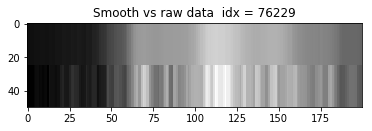

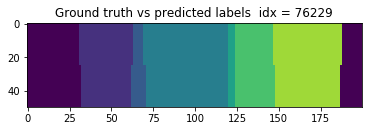

Batch 8
[(21307, 0.88999999), (30685, 0.875), (32418, 0.89499998), (63539, 0.88999999), (75581, 0.87)]
[(28965, 0.875), (33486, 0.89999998), (61571, 0.87), (68785, 0.89999998), (75916, 0.875), (11222, 0.87), (28702, 0.88999999), (32489, 0.89999998), (40974, 0.73499995), (68327, 0.79999995), (76827, 0.78999996), (17967, 0.89999998), (35338, 0.88), (39689, 0.89499998), (58779, 0.88), (63527, 0.89999998), (72863, 0.83499998), (24014, 0.87), (35646, 0.83999997), (42518, 0.87), (58750, 0.83499998), (68681, 0.89999998), (70579, 0.89999998), (75420, 0.89499998), (77545, 0.89499998), (4541, 0.89499998), (9741, 0.82999998), (10798, 0.88999999), (27388, 0.88), (31578, 0.81999999), (37991, 0.85999995), (38200, 0.83499998), (45302, 0.88999999), (67201, 0.84499997), (72757, 0.71999997), (75953, 0.85999995), (9754, 0.88499999), (11219, 0.83999997), (30683, 0.88999999), (31383, 0.83499998), (55341, 0.88999999), (55360, 0.88499999), (75831, 0.89999998), (5652, 0.83999997), (10813, 0.875), (17808, 0.88

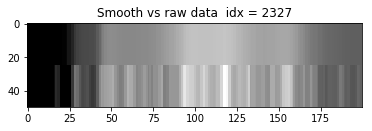

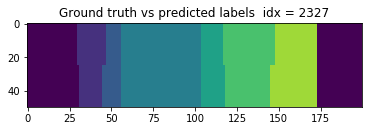

Batch 9
[(2708, 0.88), (14864, 0.89499998), (42487, 0.85499996), (46420, 0.89499998), (57917, 0.89499998), (58759, 0.875), (67189, 0.78499997), (76160, 0.89999998)]
[(28965, 0.875), (33486, 0.89999998), (61571, 0.87), (68785, 0.89999998), (75916, 0.875), (11222, 0.87), (28702, 0.88999999), (32489, 0.89999998), (40974, 0.73499995), (68327, 0.79999995), (76827, 0.78999996), (17967, 0.89999998), (35338, 0.88), (39689, 0.89499998), (58779, 0.88), (63527, 0.89999998), (72863, 0.83499998), (24014, 0.87), (35646, 0.83999997), (42518, 0.87), (58750, 0.83499998), (68681, 0.89999998), (70579, 0.89999998), (75420, 0.89499998), (77545, 0.89499998), (4541, 0.89499998), (9741, 0.82999998), (10798, 0.88999999), (27388, 0.88), (31578, 0.81999999), (37991, 0.85999995), (38200, 0.83499998), (45302, 0.88999999), (67201, 0.84499997), (72757, 0.71999997), (75953, 0.85999995), (9754, 0.88499999), (11219, 0.83999997), (30683, 0.88999999), (31383, 0.83499998), (55341, 0.88999999), (55360, 0.88499999), (75831,

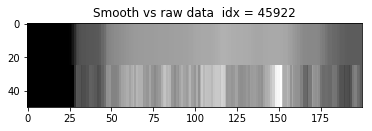

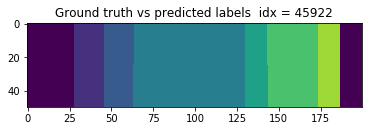

Batch 10
[(5614, 0.89999998), (11237, 0.84999996), (17969, 0.89499998), (28909, 0.79999995), (53974, 0.82999998), (72758, 0.83499998)]
[(28965, 0.875), (33486, 0.89999998), (61571, 0.87), (68785, 0.89999998), (75916, 0.875), (11222, 0.87), (28702, 0.88999999), (32489, 0.89999998), (40974, 0.73499995), (68327, 0.79999995), (76827, 0.78999996), (17967, 0.89999998), (35338, 0.88), (39689, 0.89499998), (58779, 0.88), (63527, 0.89999998), (72863, 0.83499998), (24014, 0.87), (35646, 0.83999997), (42518, 0.87), (58750, 0.83499998), (68681, 0.89999998), (70579, 0.89999998), (75420, 0.89499998), (77545, 0.89499998), (4541, 0.89499998), (9741, 0.82999998), (10798, 0.88999999), (27388, 0.88), (31578, 0.81999999), (37991, 0.85999995), (38200, 0.83499998), (45302, 0.88999999), (67201, 0.84499997), (72757, 0.71999997), (75953, 0.85999995), (9754, 0.88499999), (11219, 0.83999997), (30683, 0.88999999), (31383, 0.83499998), (55341, 0.88999999), (55360, 0.88499999), (75831, 0.89999998), (5652, 0.8399999

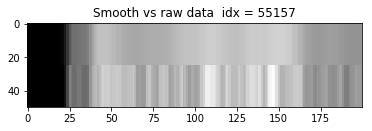

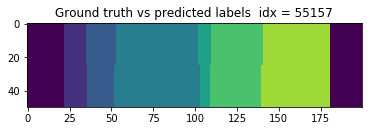

Batch 11
[(2743, 0.88999999), (32418, 0.89499998), (32489, 0.89999998), (38200, 0.83499998), (46420, 0.89499998), (68327, 0.79499996), (76798, 0.87)]
[(28965, 0.875), (33486, 0.89999998), (61571, 0.87), (68785, 0.89999998), (75916, 0.875), (11222, 0.87), (28702, 0.88999999), (32489, 0.89999998), (40974, 0.73499995), (68327, 0.79999995), (76827, 0.78999996), (17967, 0.89999998), (35338, 0.88), (39689, 0.89499998), (58779, 0.88), (63527, 0.89999998), (72863, 0.83499998), (24014, 0.87), (35646, 0.83999997), (42518, 0.87), (58750, 0.83499998), (68681, 0.89999998), (70579, 0.89999998), (75420, 0.89499998), (77545, 0.89499998), (4541, 0.89499998), (9741, 0.82999998), (10798, 0.88999999), (27388, 0.88), (31578, 0.81999999), (37991, 0.85999995), (38200, 0.83499998), (45302, 0.88999999), (67201, 0.84499997), (72757, 0.71999997), (75953, 0.85999995), (9754, 0.88499999), (11219, 0.83999997), (30683, 0.88999999), (31383, 0.83499998), (55341, 0.88999999), (55360, 0.88499999), (75831, 0.89999998), (

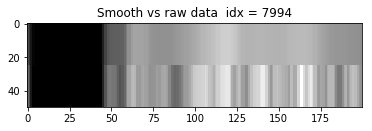

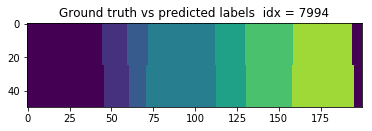

n_per region  [  0 138   0 501 245 222 231 239 738 644 388 388 243 455 315 176 165 442
 586  52 182 192  65 318 388 473 249 472 324 354 459 259 430 111  91 299
 232   1 141  56  99 182 177]
Per region accuracy [        nan  0.97663039         nan  0.97441116  0.97861219  0.98081078
  0.9742857   0.97447695  0.98046067  0.97775617  0.97855668  0.97841492
  0.97711929  0.97664832  0.97860313  0.97338065  0.97436359  0.97645926
  0.9799317   0.97605765  0.9770329   0.97304684  0.95723074  0.97838046
  0.97654635  0.98021141  0.98718872  0.98083681  0.97413577  0.97871465
  0.97759255  0.97175673  0.97970925  0.95909908  0.96851646  0.98091968
  0.97745688  0.85999995  0.9794326   0.96089283  0.96196966  0.97068677
  0.97251409]
simple_model_lrate=0.0005_fil=64_fsizes=[25]_depth=8_data=both_decay=0.001_pat=25
FINAL MODEL: err test  0.057639, acc test 0.977143, jacc test 0.941346, 0.9 accuracy 0.993474
Per sample accuracy: [ 0.99930125  0.99795499  0.99347415  0.94813943] achieve [0.8, 0.85

In [48]:
n_per_region_val, per_region_accuracy_val, worst_indices_val = test_and_plot(exp_name, val_iter)

In [50]:
only_idx_val = [worst_indices_val[i][0] for i in range(len(worst_indices_val))]
print np.sort(only_idx_val)

[ 2708  2743  4541  5614  5652  9741  9754 10798 10813 11219 11222 11237
 14864 17808 17967 17969 21307 24014 24640 27388 28702 28909 28965 30683
 30685 31383 31578 32418 32418 32489 32489 33486 35338 35646 37991 38200
 38200 39689 40974 42487 42518 43594 45302 46420 46420 53974 55341 55360
 57917 58750 58759 58779 61571 63527 63539 67189 67201 68327 68327 68681
 68785 70579 72757 72758 72761 72863 75420 75581 75831 75916 75953 76160
 76798 76798 76827 77545]


In [43]:
#a = np.sort(worst_indices_val, axis=0)
a = worst_indices_val
a2 = [(a[i][0],a[i][1], idx2regions[a[i][0]]) for i in range(len(a))]
for elem in a2:
    print elem

(24640, 0.88999999, 12)
(28965, 0.875, 16)
(32418, 0.89499998, 13)
(35646, 0.83999997, 14)
(38200, 0.83999997, 18)
(58759, 0.875, 28)
(67201, 0.84499997, 33)
(68918, 0.89999998, 31)
(70579, 0.89999998, 32)
(75420, 0.89499998, 38)
(76827, 0.78999996, 39)
(42487, 0.84999996, 24)
(11222, 0.87, 12)
(11237, 0.84999996, 12)
(21307, 0.88999999, 8)
(45302, 0.88499999, 21)
(63527, 0.89499998, 30)
(68327, 0.79999995, 31)
(72863, 0.83999997, 33)
(75953, 0.85999995, 37)
(2708, 0.875, 4)
(4541, 0.89499998, 3)
(33486, 0.89999998, 13)
(40974, 0.73499995, 22)
(53974, 0.83499998, 30)
(58779, 0.87, 28)
(66692, 0.89999998, 36)
(27388, 0.875, 15)
(31578, 0.815, 17)
(61571, 0.87, 27)
(10813, 0.875, 9)
(42518, 0.87, 23)
(57917, 0.89499998, 29)
(59505, 0.89999998, 27)
(70159, 0.88499999, 34)
(72760, 0.69999999, 33)
(5652, 0.83999997, 3)
(11219, 0.83999997, 12)
(31383, 0.83499998, 17)
(35338, 0.88499999, 14)
(67189, 0.78499997, 33)
(68681, 0.89999998, 31)
(72757, 0.71999997, 33)
(72758, 0.83999997, 33)
(77545

Batch 0


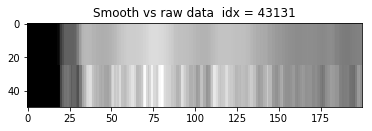

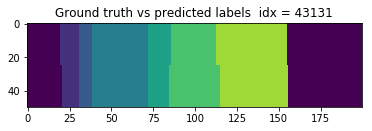

Batch 1


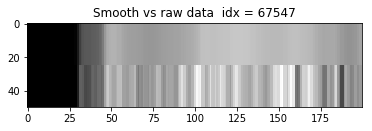

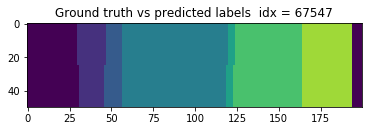

Batch 2


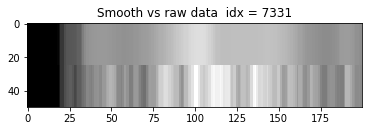

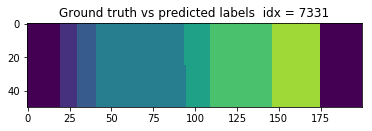

Batch 3


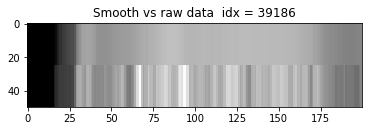

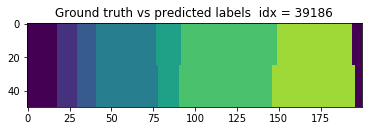

Batch 4


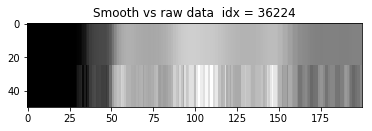

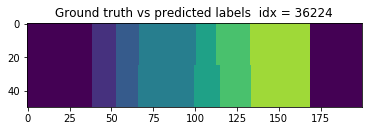

Batch 5


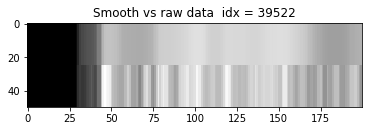

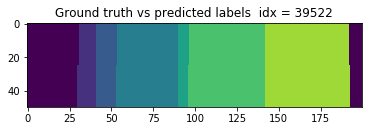

Batch 6


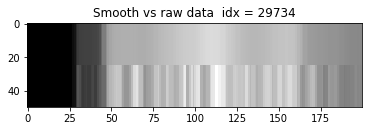

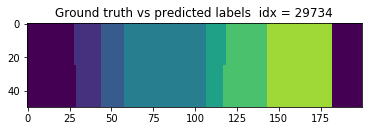

Batch 7


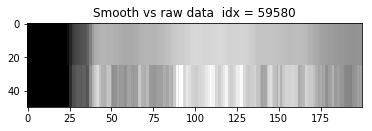

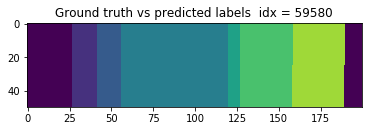

Batch 8


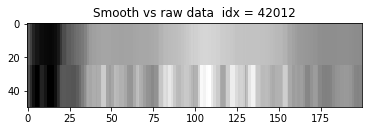

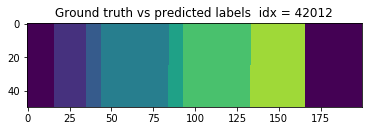

Batch 9


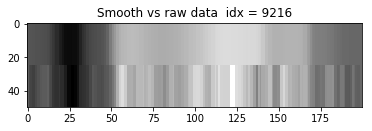

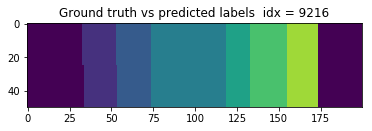

Batch 10


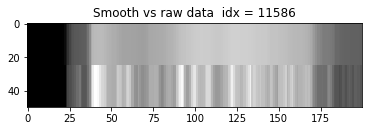

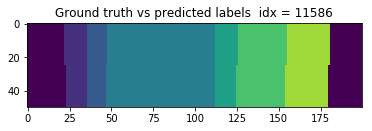

Batch 11


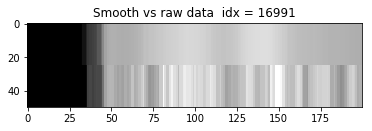

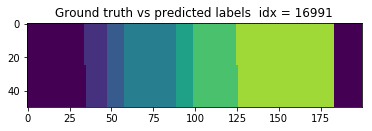

Batch 12


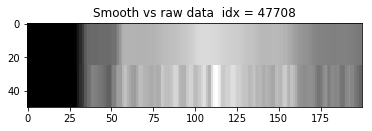

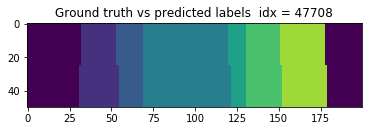

Batch 13


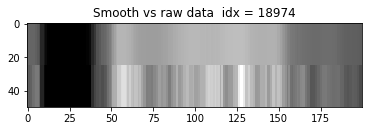

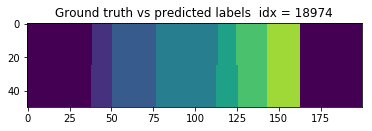

Batch 14


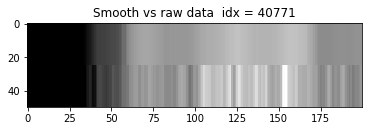

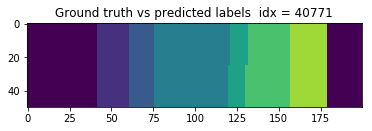

Batch 15


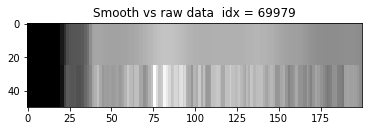

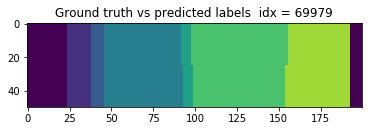

Batch 16


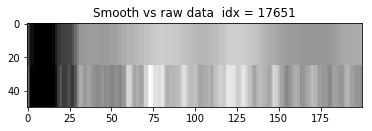

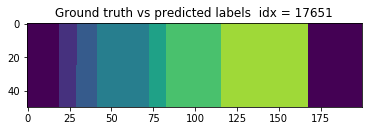

Batch 17


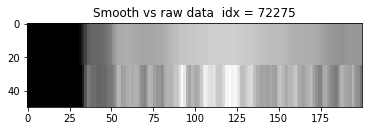

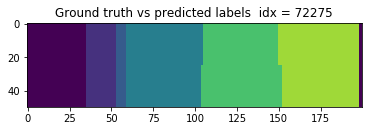

Batch 18


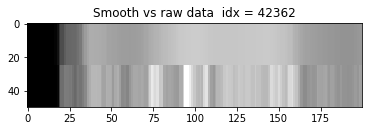

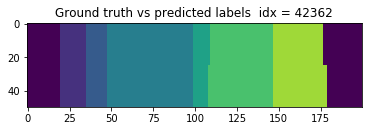

Batch 19


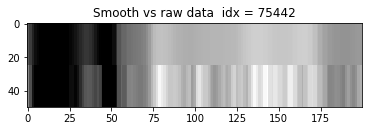

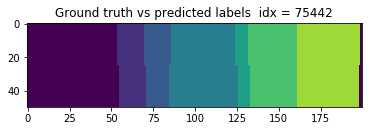

Batch 20


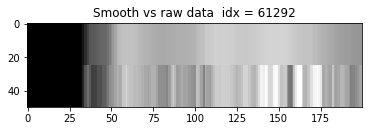

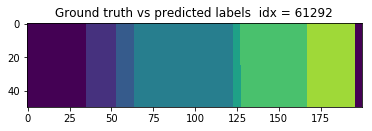

Batch 21


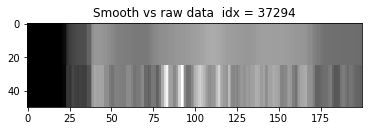

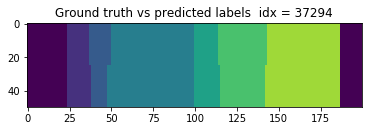

Batch 22


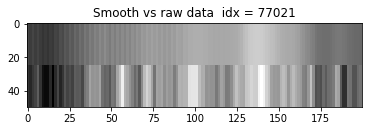

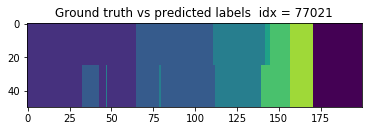

Batch 23


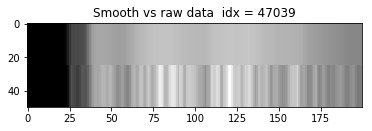

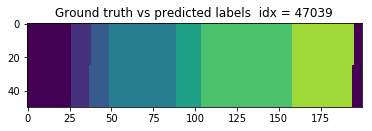

Batch 24


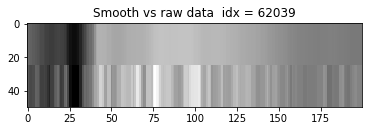

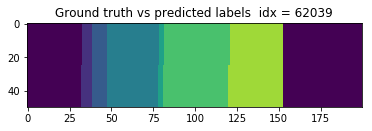

Batch 25


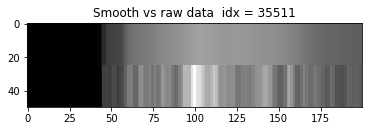

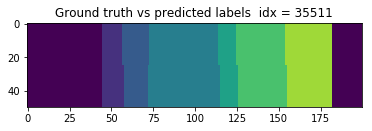

Batch 26


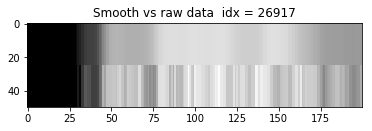

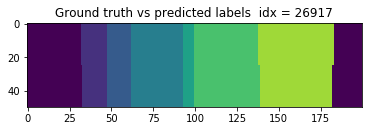

Batch 27


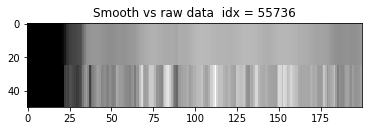

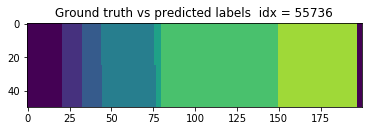

Batch 28


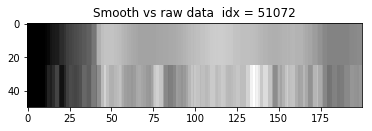

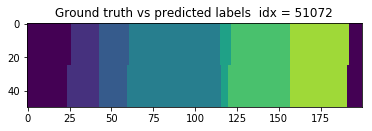

Batch 29


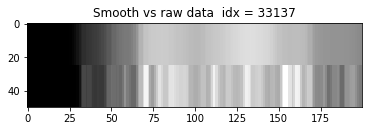

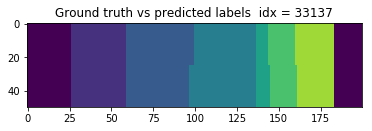

Batch 30


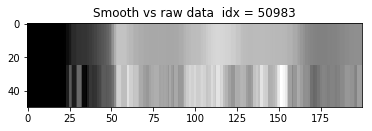

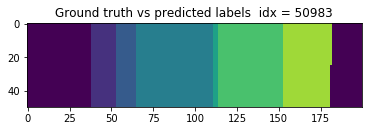

Batch 31


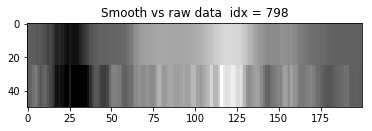

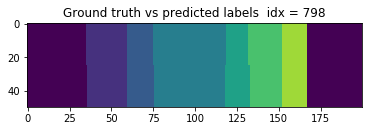

Batch 32


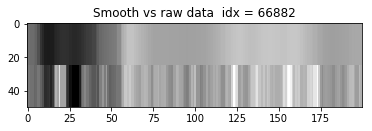

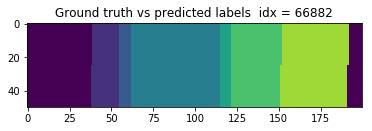

Batch 33


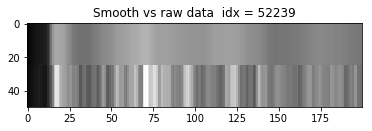

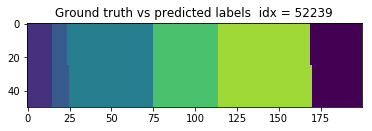

Batch 34


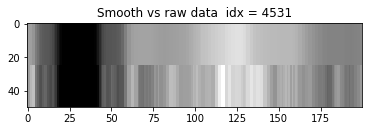

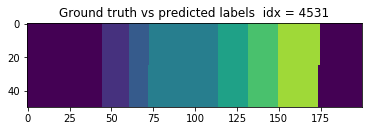

Batch 35


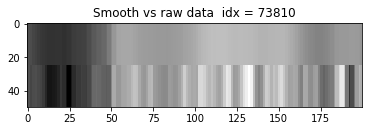

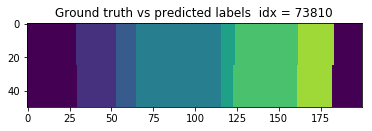

Batch 36


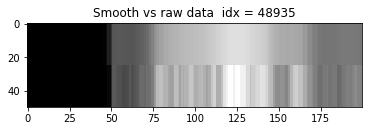

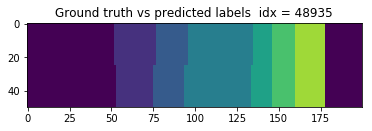

Batch 37


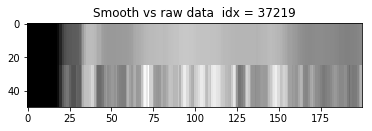

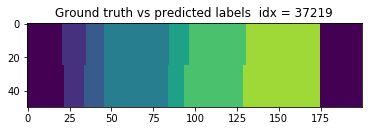

Batch 38


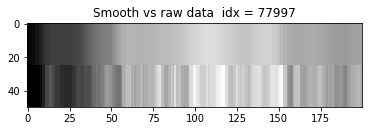

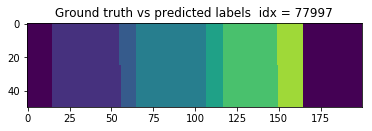

Batch 39


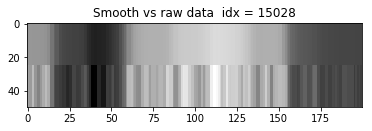

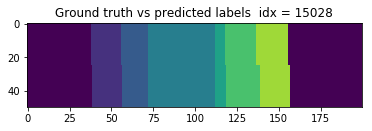

Batch 40


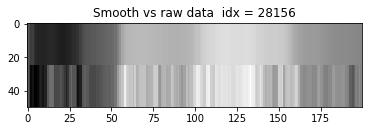

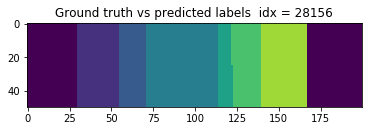

Batch 41


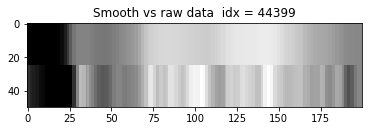

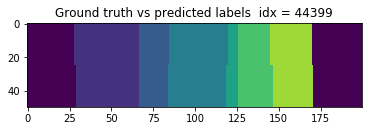

Batch 42


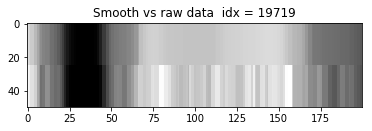

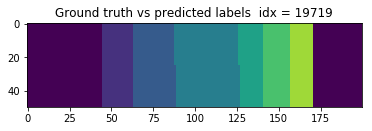

Batch 43


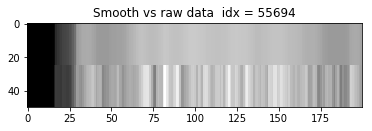

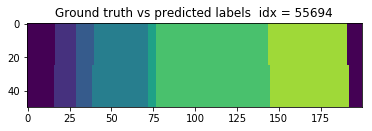

Batch 44


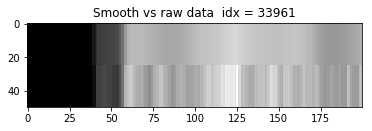

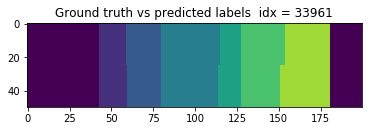

Batch 45


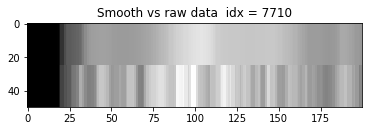

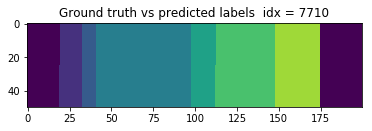

Batch 46


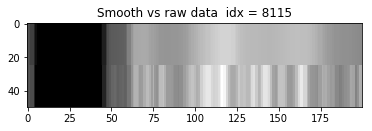

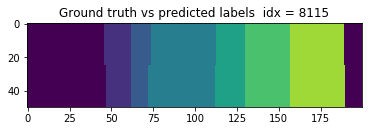

Batch 47


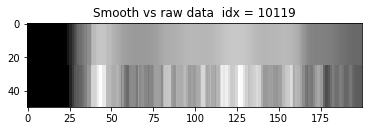

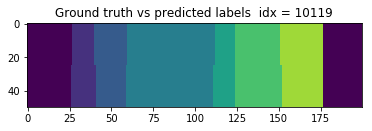

Batch 48


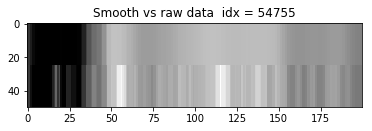

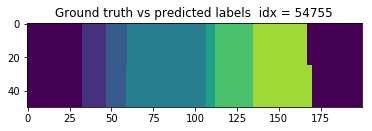

Batch 49


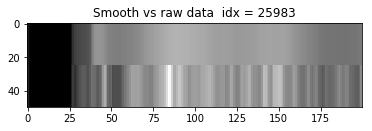

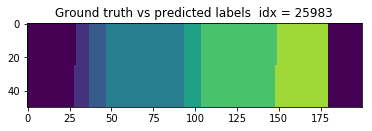

Batch 50


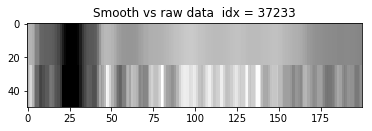

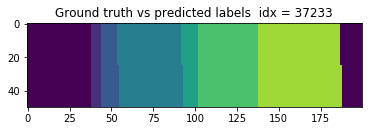

Batch 51


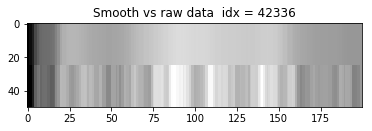

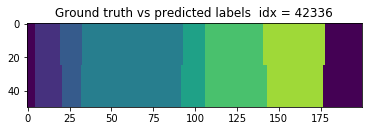

Batch 52


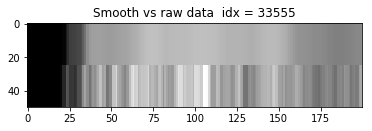

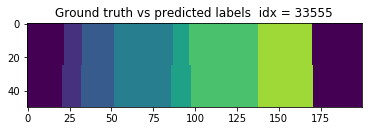

Batch 53


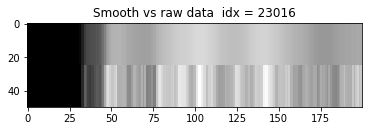

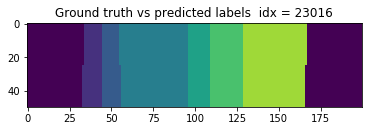

Batch 54


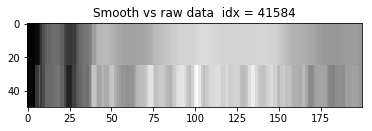

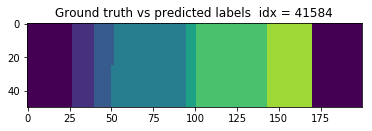

Batch 55


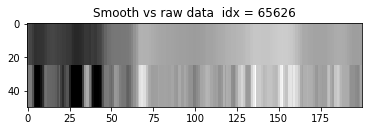

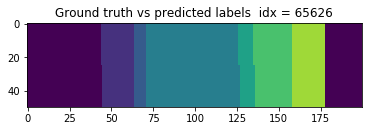

Batch 56


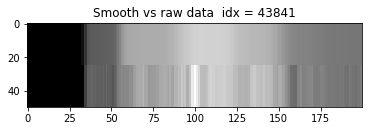

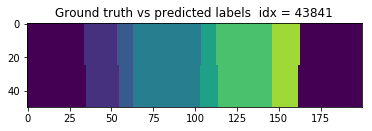

Batch 57


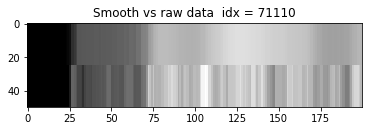

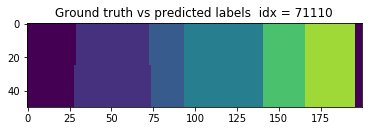

Batch 58


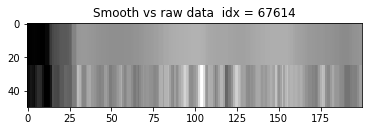

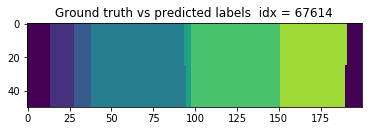

Batch 59


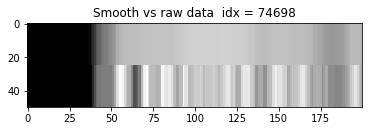

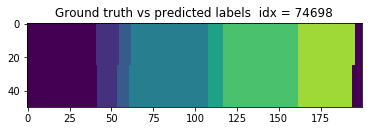

Batch 60


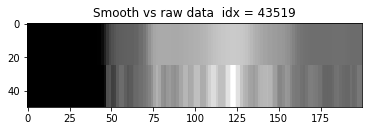

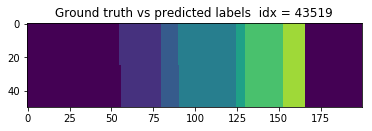

Batch 61


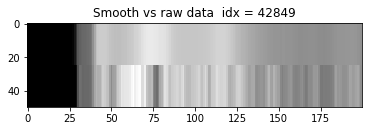

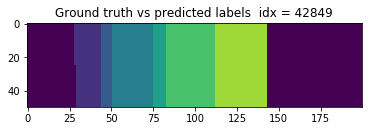

Batch 62


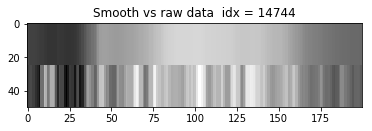

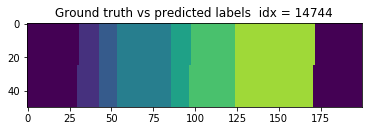

Batch 63


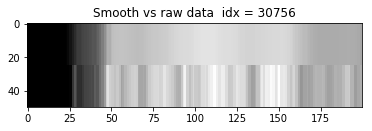

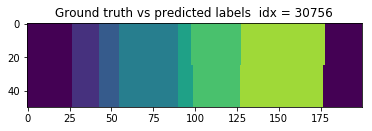

Batch 64


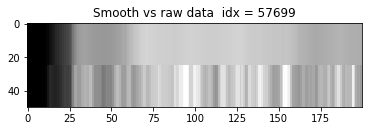

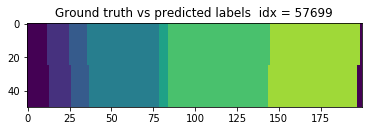

Batch 65


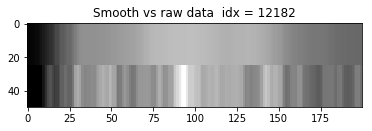

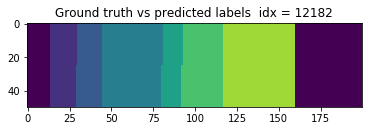

Batch 66


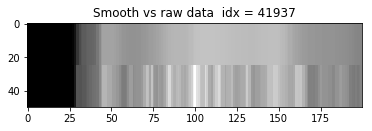

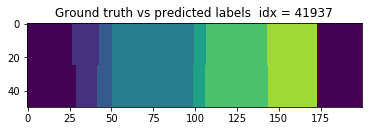

n_per region  [   0  757    0 2821 1248 1256 1230 1354 4507 3401 2521 2271 1407 2534 1777
 1066  893 2542 3253  303 1032 1076  283 1933 2361 2744 1686 2519 1626 2003
 2684 1411 2336  590  503 1482 1342   12  764  346  515 1060  970]
Per region accuracy [        nan  0.97764858         nan  0.97710382  0.98140621  0.9821616
  0.97836988  0.97977471  0.98213885  0.98179062  0.98070009  0.98163361
  0.98034111  0.98112072  0.98046986  0.97735925  0.97661251  0.9804386
  0.98243003  0.97394387  0.97952517  0.97658454  0.97159007  0.98004394
  0.98013127  0.98341834  0.98911327  0.98335248  0.97794277  0.98065648
  0.98050108  0.97636423  0.98208258  0.96940675  0.97577531  0.98190955
  0.97951189  0.94249999  0.98037955  0.96736991  0.97542715  0.97792921
  0.97741749]
simple_model_lrate=0.0005_fil=64_fsizes=[25]_depth=8_data=both_decay=0.001_pat=25
FINAL MODEL: err test  0.048995, acc test 0.980411, jacc test 0.949235, 0.9 accuracy 0.998896
Per sample accuracy: [ 0.9999403   0.99967164  0

In [24]:
n_per_region_train, per_region_accuracy_train, worst_indices_train = test_and_plot(exp_name, train_iter)

In [44]:
a_train = worst_indices_train

a2_train = [(a_train[i][0],a_train[i][1], idx2regions[a_train[i][0]]) for i in range(len(a_train))]
for elem in a2_train:
    print elem

(27927, 0.82999998, 18)
(76962, 0.89499998, 39)
(70526, 0.89999998, 32)
(42522, 0.875, 23)
(47303, 0.89999998, 22)
(59764, 0.89999998, 27)
(17863, 0.88999999, 9)
(1660, 0.85999995, 3)
(24623, 0.89499998, 12)
(1658, 0.85999995, 3)
(13629, 0.85999995, 11)
(75993, 0.875, 42)
(5610, 0.84999996, 3)
(31403, 0.88999999, 17)
(75917, 0.87, 40)
(48189, 0.88499999, 23)
(76261, 0.87, 42)
(27783, 0.82999998, 18)
(42527, 0.88, 23)
(38194, 0.81999999, 18)
(426, 0.88999999, 1)
(75960, 0.875, 37)
(24283, 0.89999998, 12)
(1640, 0.88499999, 3)
(53216, 0.89999998, 26)
(42531, 0.89499998, 23)
(1659, 0.84999996, 3)
(43588, 0.78999996, 23)
(55906, 0.89999998, 25)
(23061, 0.88, 9)
(38231, 0.83499998, 18)
(42541, 0.88, 23)
(37993, 0.82999998, 18)
(2833, 0.875, 4)
(38017, 0.83999997, 18)
(59489, 0.89999998, 28)
(28779, 0.89499998, 17)
(415, 0.89499998, 1)
(13485, 0.88, 11)
(77757, 0.85999995, 40)
(5623, 0.83999997, 3)
(37992, 0.84499997, 18)
(5599, 0.83999997, 3)
(24007, 0.89499998, 9)
(39691, 0.89499998, 18)
(

Batch 0


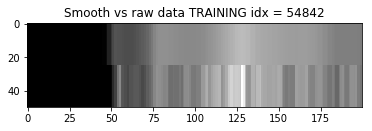

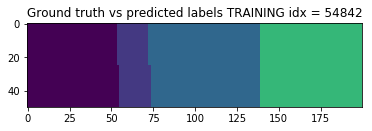

Batch 1


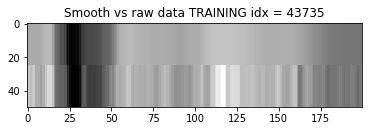

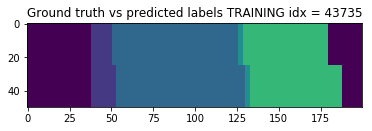

Batch 2


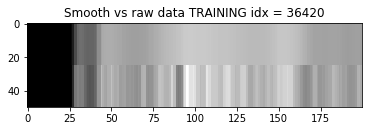

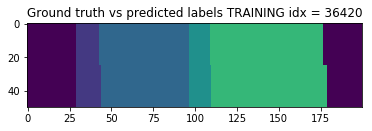

Batch 3


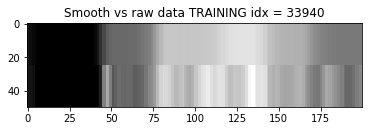

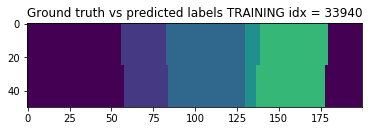

Batch 4


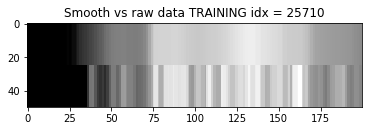

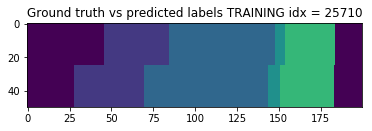

Batch 5


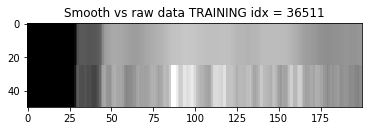

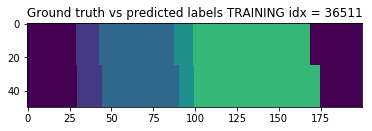

Batch 6


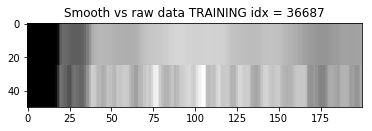

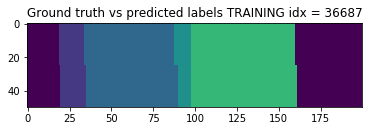

Batch 7


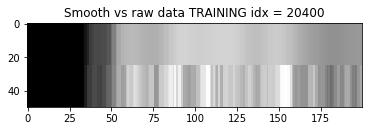

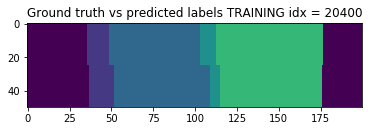

Batch 8


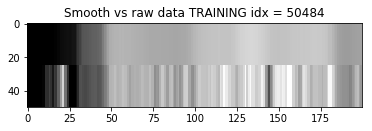

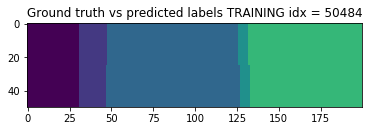

Batch 9


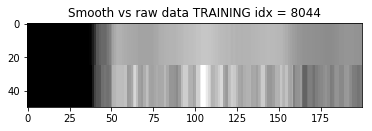

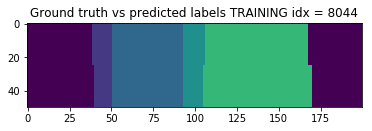

Batch 10


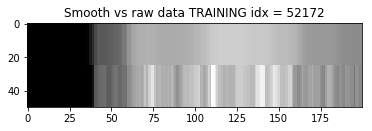

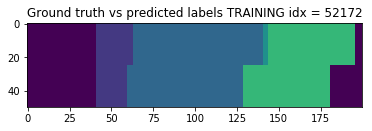

Batch 11


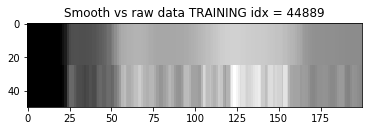

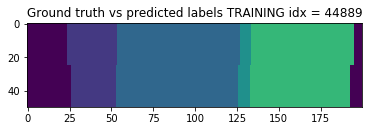

Batch 12


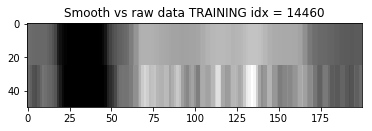

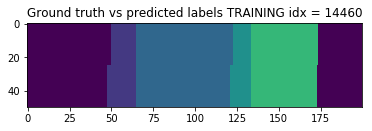

Batch 13


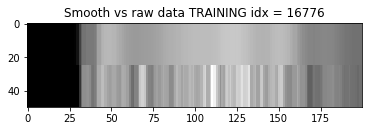

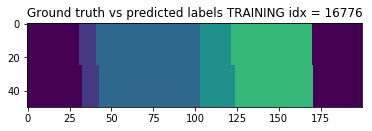

Batch 14


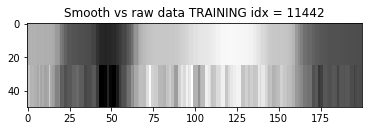

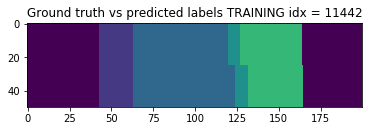

Batch 15


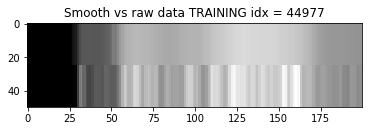

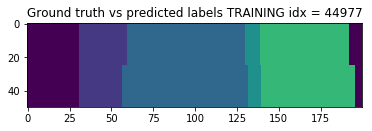

Batch 16


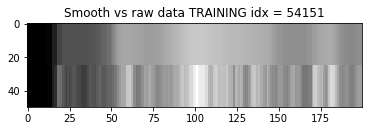

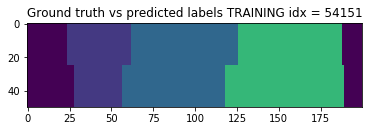

Batch 17


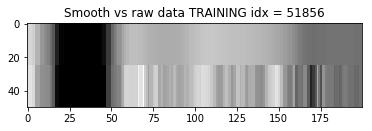

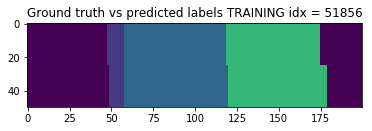

Batch 18


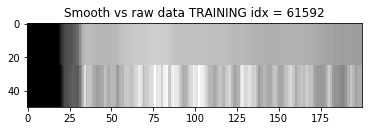

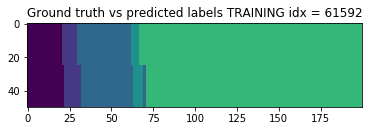

Batch 19


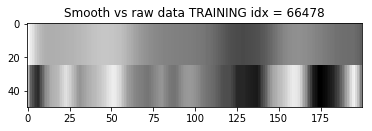

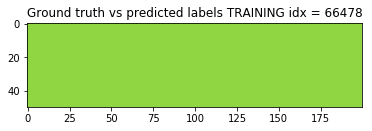

Batch 20


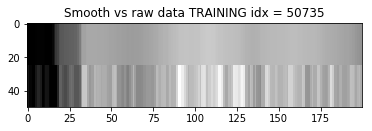

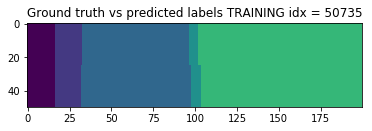

simple_model_lrate=0.0005_fil=64_fsizes=[25]_depth=8_data=both_decay=0.001_pat=25nothreads
FINAL MODEL: err test  0.177287, acc test 0.935100, jacc test 0.843244, 0.9 accuracy 0.804635
Per sample accuracy: [ 0.94006349  0.89253968  0.80463492  0.5711746 ] achieve [0.8, 0.85, 0.9, 0.95] accuracy


In [23]:
test_and_plot(exp_name, val_iter)

0


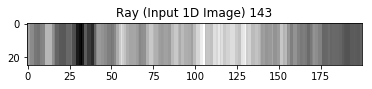

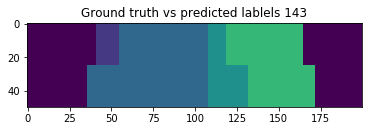

1


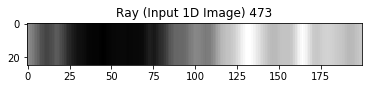

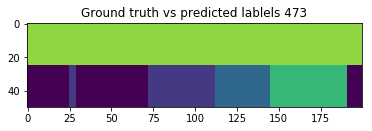

2


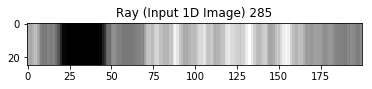

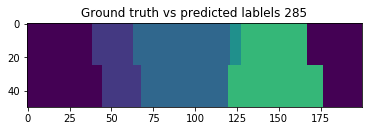

3


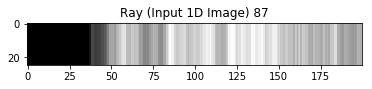

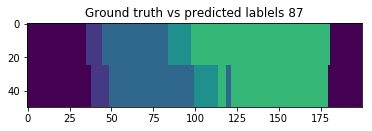

4


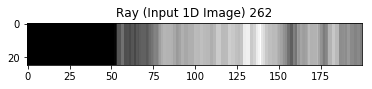

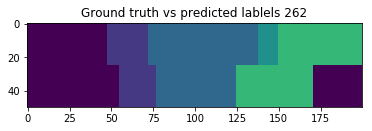

5


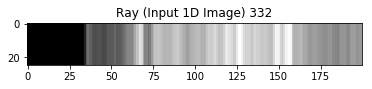

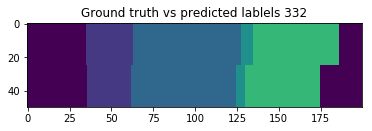

6


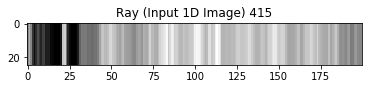

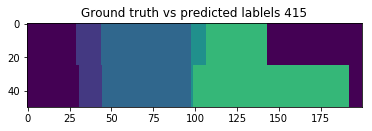

7


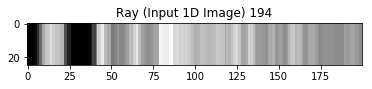

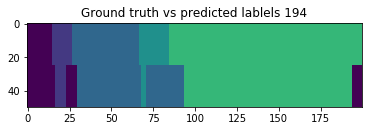

8


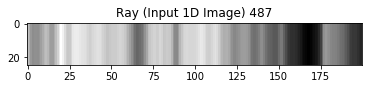

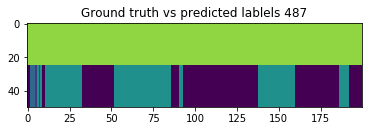

9


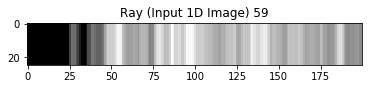

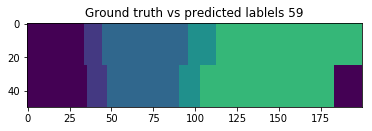

10


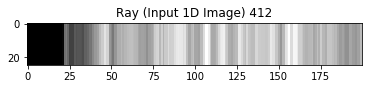

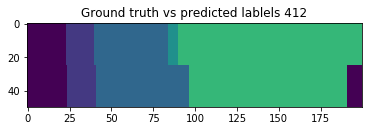

11


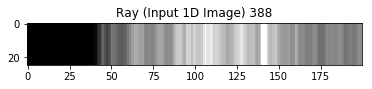

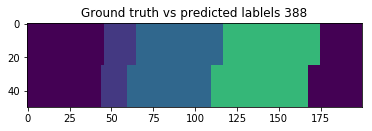

12


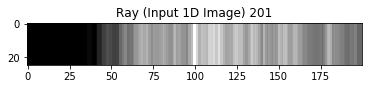

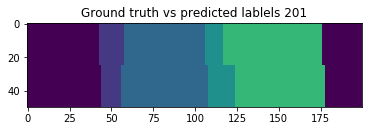

13


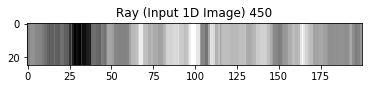

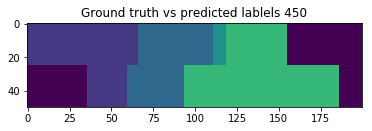

14


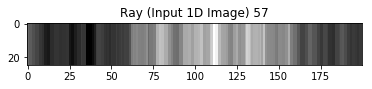

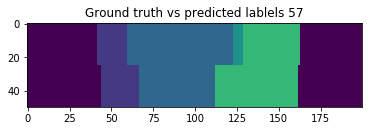

15


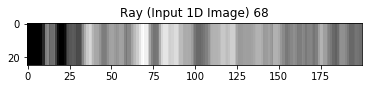

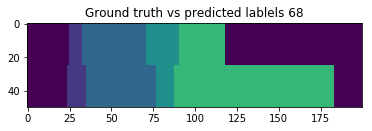

16


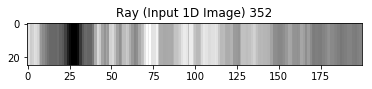

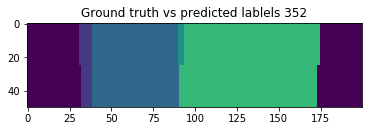

17


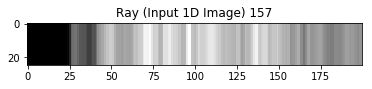

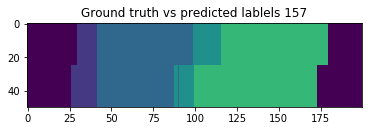

18


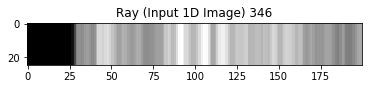

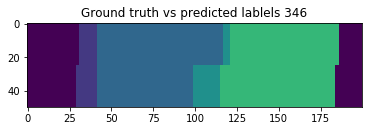

19


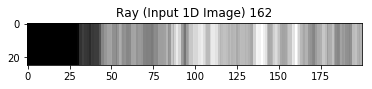

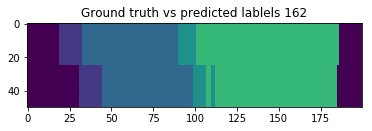

20


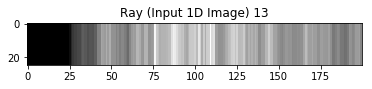

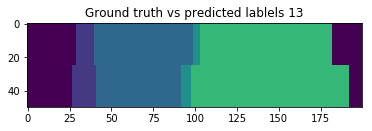

FINAL MODEL: err test  0.479910, acc test 0.803833, jacc test 0.515970


In [21]:
exp_name_2 = 'simple_model_lrate=0.0005_fil=512_fsizes=[3, 5, 11, 25, 51, 99]_raw_decay=0.0001_pat=25'
test_and_plot(exp_name_2, val_iter)

0


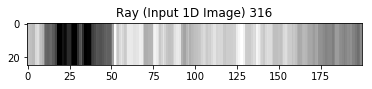

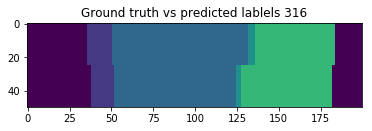

1


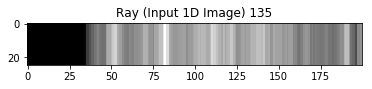

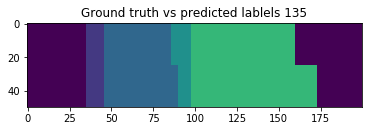

2


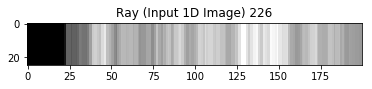

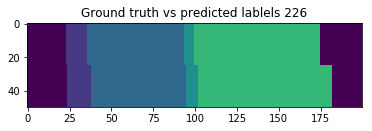

3


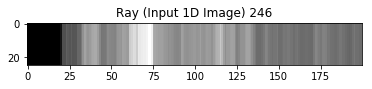

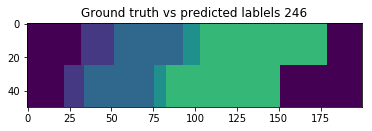

4


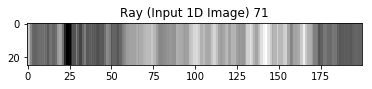

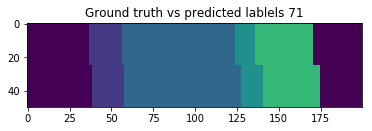

5


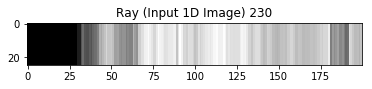

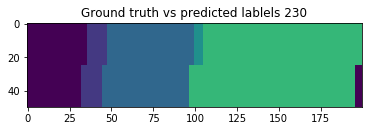

6


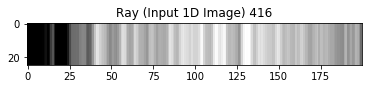

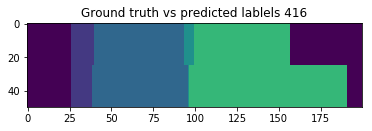

7


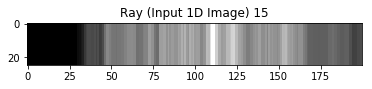

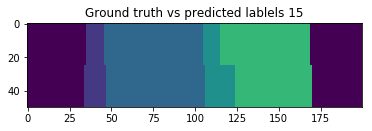

8


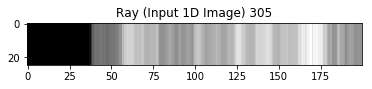

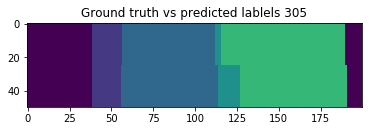

9


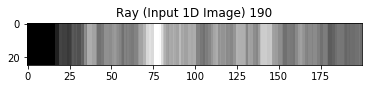

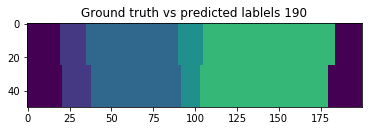

10


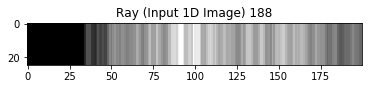

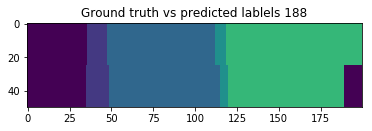

11


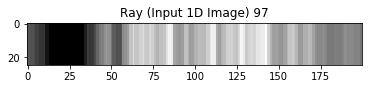

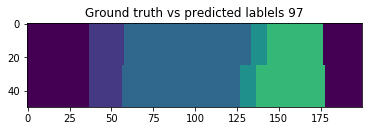

12


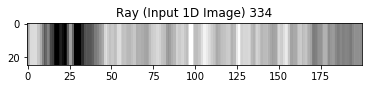

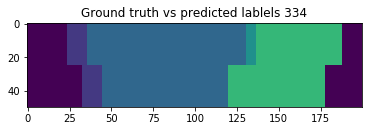

13


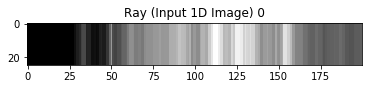

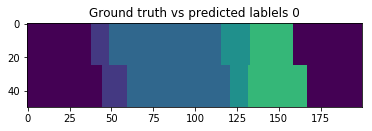

14


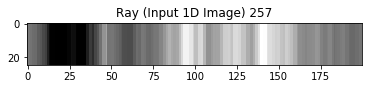

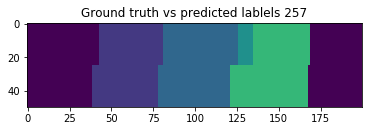

15


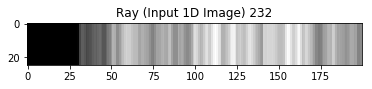

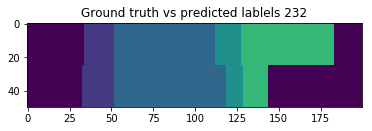

16


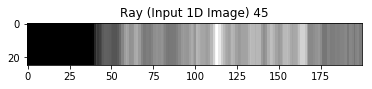

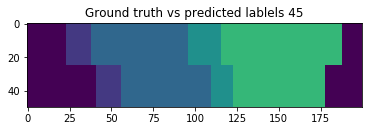

17


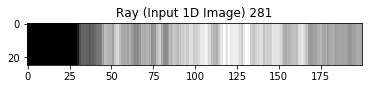

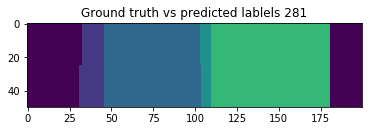

18


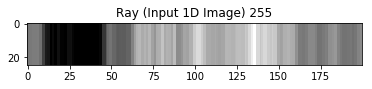

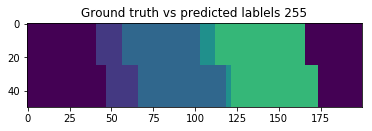

19


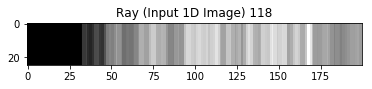

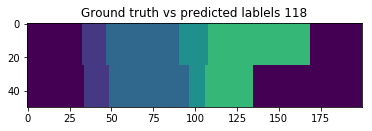

20


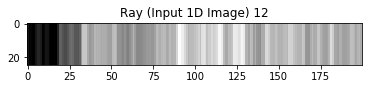

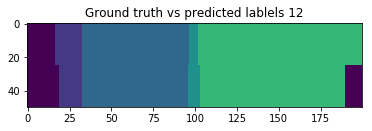

FINAL MODEL: err test  0.269041, acc test 0.901557, jacc test 0.779184


In [15]:
#previous best model
